# Analísis de comportamiento de clientes para la tienda de comestibles
### Enunciado del problema
Una tienda de comestibles quiere conocer mejor a sus clientes para poder crear campañas de marketing personalizadas. Se le pide que desarrolle un modelo de clasificación utilizando Keras que tenga en cuenta la frecuencia de compra de los clientes, sus hábitos de gasto y la cantidad máxima que gastan en la tienda. El objetivo del modelo es clasificar a los clientes en tres categorías: valor bajo, medio y alto.
Datos de entrenamiento adjuntos en un archivo llamado data_customer_classification

### 1. Importar los datos a un data frame y mostrar su contenido inicial

In [2]:
#instalación de librerias
#!pip install openpyxl
#!pip install -U scikit-learn
# !pip install -U seaborn
# !pip install -U matplotlib
# %pip install -U keras
#%pip install -U tensorflow

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

In [5]:
data= pd.read_excel(io="Datos/data_customer_classification.xlsx", sheet_name="in")
data.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
#validar si hay datos vacios
array2=[]
def isNaN(num):
    return num != num

for col in data:
  array=data[col].unique()
  for dato in array:
    if(isNaN(dato)):
      array2.append(col)
      continue
print(array2)

[]


El dataframe no contiene ninguna columna vacía

### 2. Análisis estádistico básico.

In [7]:
### validar los tipos de datos que contienen cada columna del DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [8]:
data.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


### 3. Preparación de los datos 

In [9]:
# Calcular la frecuencia de compra por cliente
shopping_frequency = data.groupby('customer_id').size().reset_index(name='shopping_frequency')

# Calcular el monto máximo de transacción por cliente
tran_amount_max = data.groupby('customer_id')['tran_amount'].max().reset_index(name='tran_amount_max')

# Calcular el monto promedio de transacción por cliente
tran_amount_mean = data.groupby('customer_id')['tran_amount'].mean().reset_index(name='tran_amount_mean')

# Convertir la columna 'trans_date' a tipo datetime
data['trans_date'] = pd.to_datetime(data['trans_date'])

# Calcular la fecha más reciente y la fecha más antigua para cada cliente
customer_date_range = data.groupby('customer_id')['trans_date'].agg(['min', 'max']).reset_index()

# Calcular la diferencia entre la fecha más reciente y la fecha más antigua
customer_date_range['date_range'] = customer_date_range['max'] - customer_date_range['min']

# Convertir la diferencia de fechas a días
customer_date_range['date_range_days'] = customer_date_range['date_range'].dt.days

# Unir todos los cálculos al DataFrame original
customer_features = shopping_frequency.merge(tran_amount_max, on='customer_id')\
                                    .merge(tran_amount_mean, on='customer_id')\
                                    .merge(customer_date_range[['customer_id', 'date_range_days']], on='customer_id')
customer_features

,customer_id,shopping_frequency,tran_amount_max,tran_amount_mean,date_range_days
0,CS1112,15,105,67.466667,1309
1,CS1113,20,98,74.500000,1354
2,CS1114,19,105,75.368421,1309
3,CS1115,22,104,75.409091,1303
4,CS1116,13,105,65.923077,1155
...,...,...,...,...,...
6884,CS8996,13,79,44.769231,1120
6885,CS8997,14,75,38.785714,1116
6886,CS8998,13,79,48.000000,1293
6887,CS8999,12,64,31.916667,1073


#### 3.1 Clasificación en los grupos valor bajo, medio y alto.

In [10]:
#Clasificación en los grupos valor bajo, medio y alto.
# Estandarizar las características (frecuencia de compra, monto máximo gastado, monto promedio gastado y rango de fechas)
customer_features_standardized = (customer_features[['shopping_frequency', 'tran_amount_max', 'tran_amount_mean', 'date_range_days']] - customer_features[['shopping_frequency', 'tran_amount_max', 'tran_amount_mean', 'date_range_days']].mean()) / customer_features[['shopping_frequency', 'tran_amount_max', 'tran_amount_mean', 'date_range_days']].std()

# Calcular la puntuación Z promedio para cada cliente resultado de aplicar la normalización basada en la desviación estándar.
customer_features_standardized['z_score'] = customer_features_standardized.mean(axis=1)

# Definir los límites entre los grupos (bajo, medio, alto) basados en los percentiles
low_limit = customer_features_standardized['z_score'].quantile(1/3)
high_limit = customer_features_standardized['z_score'].quantile(2/3)

# Función para clasificar a los clientes en grupos
def classify_group(z_score):
    if z_score <= low_limit:
        return 'valor bajo'
    elif z_score <= high_limit:
        return 'valor medio'
    else:
        return 'valor alto'

# Agregar una columna con la clasificación de los clientes en los tres grupos
customer_features['group'] = customer_features_standardized['z_score'].apply(classify_group)

# Mostrar el DataFrame resultante
customer_features

,customer_id,shopping_frequency,tran_amount_max,tran_amount_mean,date_range_days,group
0,CS1112,15,105,67.466667,1309,valor medio
1,CS1113,20,98,74.500000,1354,valor alto
2,CS1114,19,105,75.368421,1309,valor alto
3,CS1115,22,104,75.409091,1303,valor alto
4,CS1116,13,105,65.923077,1155,valor bajo
...,...,...,...,...,...,...
6884,CS8996,13,79,44.769231,1120,valor bajo
6885,CS8997,14,75,38.785714,1116,valor bajo
6886,CS8998,13,79,48.000000,1293,valor bajo
6887,CS8999,12,64,31.916667,1073,valor bajo


In [44]:
#aplicar label encoding para preparar los datos
# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Aplicar label encoding a la columna 'group' esto permitirá al modelo procesar la variable categorica objetivo
customer_features['group_encoded'] = label_encoder.fit_transform(customer_features['group'])
#targets=label_encoder.inverse_transform(np.array([0, 1,2]))
#print(targets)
#['valor alto' 'valor bajo' 'valor medio']
customer_features


,customer_id,shopping_frequency,tran_amount_max,tran_amount_mean,date_range_days,group,group_encoded
0,CS1112,15,105,67.466667,1309,valor medio,2
1,CS1113,20,98,74.500000,1354,valor alto,0
2,CS1114,19,105,75.368421,1309,valor alto,0
3,CS1115,22,104,75.409091,1303,valor alto,0
4,CS1116,13,105,65.923077,1155,valor bajo,1
...,...,...,...,...,...,...,...
6884,CS8996,13,79,44.769231,1120,valor bajo,1
6885,CS8997,14,75,38.785714,1116,valor bajo,1
6886,CS8998,13,79,48.000000,1293,valor bajo,1
6887,CS8999,12,64,31.916667,1073,valor bajo,1


### 4. Gráficos estadísticos

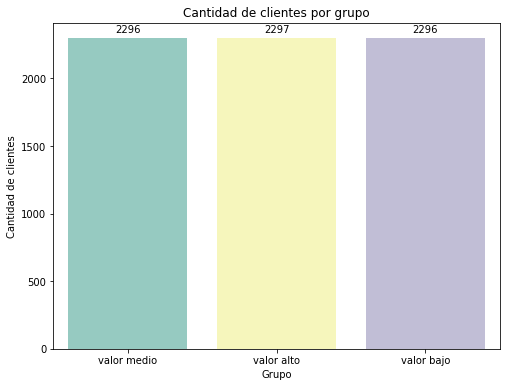

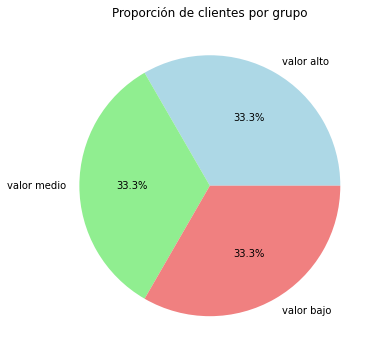

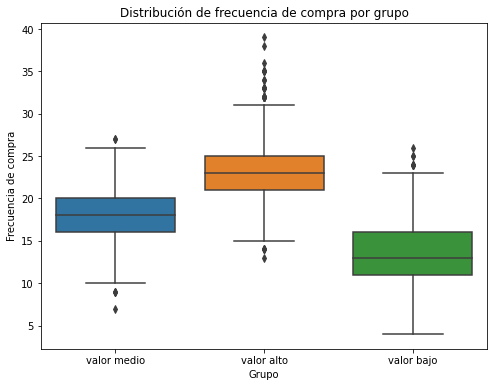

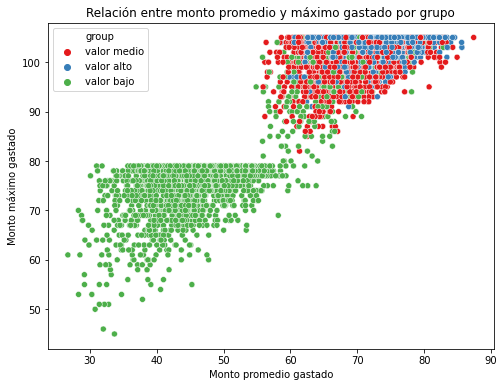

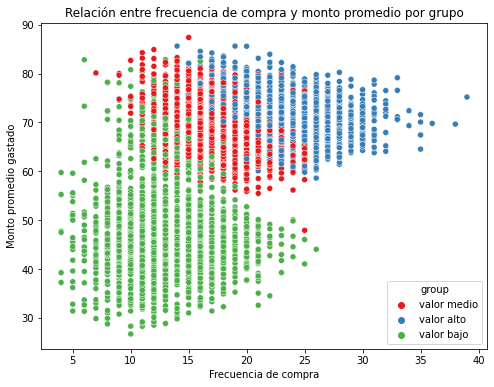

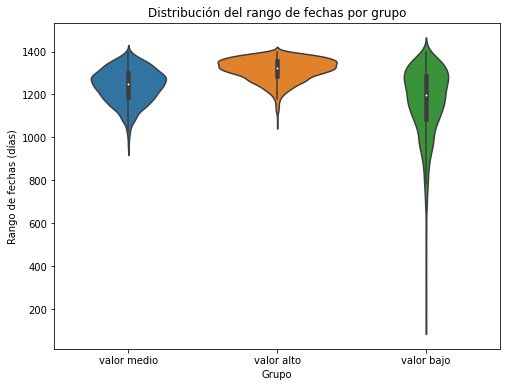

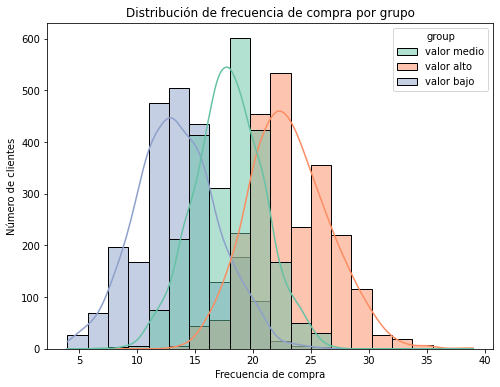

In [29]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='group', data=customer_features, palette='Set3')

# Agregar el número de cada barra sobre el mismo
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Cantidad de clientes por grupo')
plt.xlabel('Grupo')
plt.ylabel('Cantidad de clientes')
plt.show()

plt.figure(figsize=(8, 6))
customer_features['group'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Proporción de clientes por grupo')
plt.ylabel('')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='shopping_frequency', data=customer_features)
plt.title('Distribución de frecuencia de compra por grupo')
plt.xlabel('Grupo')
plt.ylabel('Frecuencia de compra')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='tran_amount_mean', y='tran_amount_max', hue='group', data=customer_features, palette='Set1')
plt.title('Relación entre monto promedio y máximo gastado por grupo')
plt.xlabel('Monto promedio gastado')
plt.ylabel('Monto máximo gastado')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='shopping_frequency', y='tran_amount_mean', hue='group', data=customer_features, palette='Set1')
plt.title('Relación entre frecuencia de compra y monto promedio por grupo')
plt.xlabel('Frecuencia de compra')
plt.ylabel('Monto promedio gastado')
plt.show()


plt.figure(figsize=(8, 6))
sns.violinplot(x='group', y='date_range_days', data=customer_features)
plt.title('Distribución del rango de fechas por grupo')
plt.xlabel('Grupo')
plt.ylabel('Rango de fechas (días)')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(x='shopping_frequency', hue='group', data=customer_features, bins=20, kde=True, palette='Set2')
plt.title('Distribución de frecuencia de compra por grupo')
plt.xlabel('Frecuencia de compra')
plt.ylabel('Número de clientes')
plt.show()


Los datos están balanceados en las tres categorias, punto importante para un entrenamiento exitoso del modelo. 

### 5. Segmentación de datos train y test

In [13]:
# Dividir los datos en características (X) y la variable objetivo (y)
X = customer_features.drop(['customer_id','group','group_encoded'], axis=1)  # características
y = customer_features['group_encoded']  # variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar la forma de los conjuntos de entrenamiento y prueba
print("Forma del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Forma del conjunto de prueba:", X_test.shape, y_test.shape)

Forma del conjunto de entrenamiento: (5511, 4) (5511,)
Forma del conjunto de prueba: (1378, 4) (1378,)


### 6. Modelo

In [24]:
model = Sequential()

# Añadir capas densas 
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))  
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las 3 categorías (valor bajo, valor medio, valor alto)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 6.1 Entrenamiento del modelo

In [25]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200


138/138 [==============================] - 1s 3ms/step - loss: 11.5149 - accuracy: 0.3950 - val_loss: 1.5519 - val_accuracy: 0.3472
Epoch 2/200
138/138 [==============================] - 0s 2ms/step - loss: 1.0810 - accuracy: 0.5220 - val_loss: 0.6811 - val_accuracy: 0.6881
Epoch 3/200
138/138 [==============================] - 0s 2ms/step - loss: 0.7850 - accuracy: 0.6363 - val_loss: 1.4652 - val_accuracy: 0.5122
Epoch 4/200
138/138 [==============================] - 0s 2ms/step - loss: 0.8207 - accuracy: 0.6468 - val_loss: 0.5863 - val_accuracy: 0.7425
Epoch 5/200
138/138 [==============================] - 0s 2ms/step - loss: 0.7727 - accuracy: 0.6695 - val_loss: 0.7069 - val_accuracy: 0.6845
Epoch 6/200
138/138 [==============================] - 0s 2ms/step - loss: 0.7469 - accuracy: 0.6772 - val_loss: 1.0540 - val_accuracy: 0.5639
Epoch 7/200
138/138 [==============================] - 0s 2ms/step - loss: 0.7562 - accuracy: 0.6772 - val_loss: 0.5209 - val_accuracy: 0.7588
Epoch 8/20

#### 6.2 Gráficas de las métricas del entrenamiento del modelo

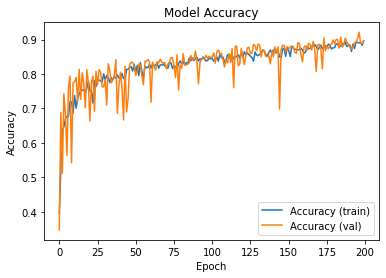

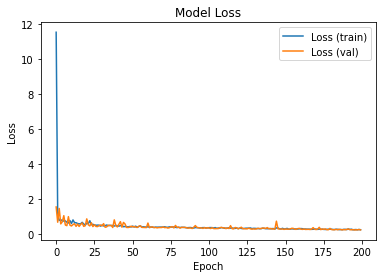

In [30]:
# Gráfico de la precisión
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfico de la pérdida
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 7. Evaluación del modelo

In [31]:
# Evaluación del modelo en el conjunto de datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Precisión en los datos de prueba:", accuracy)

44/44 [==============================] - 0s 2ms/step - loss: 0.2683 - accuracy: 0.8723
Precisión en los datos de prueba: 0.8722786903381348


In [48]:
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=-1)

# Convertir las clases verdaderas en el conjunto de datos de prueba en un solo array
y_true_classes = y_test.tolist()

precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Generar el informe de clasificación.
class_names =['Valor alto', 'Valor bajo', 'Valor medio']
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Imprimir resultados
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_rep)

44/44 [==============================] - 0s 1ms/step
Precision: [0.81663516 0.99270073 0.82648402]
Recall: [0.94117647 0.89277899 0.78354978]
F1-score: [0.87449393 0.94009217 0.80444444]
Accuracy: 0.872278664731495

Classification Report:
              precision    recall  f1-score   support

  Valor alto       0.82      0.94      0.87       459
  Valor bajo       0.99      0.89      0.94       457
 Valor medio       0.83      0.78      0.80       462

    accuracy                           0.87      1378
   macro avg       0.88      0.87      0.87      1378
weighted avg       0.88      0.87      0.87      1378



Precisión, Sensibilidad y F1-score: todas estas métricas son altas para las tres clases. Esto indica que el modelo es capaz de clasificar las instancias en cada clase; sin embargo, es posible mejorar la clasificación en las clases de valor medio y alto aplicando técnicas más avanzadas en normalización de los datos antes de entrenar el modelo y usar otras arquitectura más complejas en el modelo.

Exactitud (Accuracy): la exactitud general del modelo es del 88%, lo que significa que aproximadamente el 88% de todas las predicciones son correctas.

Reporte de Clasificación: el reporte de clasificación muestra métricas detalladas para cada clase, incluyendo precisión, sensibilidad y F1-score. Además, las métricas macro y weighted avg muestran promedios de estas métricas que tienen en cuenta el desequilibrio de clases.

Soporte (Support): el soporte muestra el número de ocurrencias reales de cada clase en el conjunto de prueba.

### 8. Exportar el modelo

In [49]:
# Guardar la arquitectura del modelo en formato JSON
model_json = model.to_json()
with open("Modelo/modelo.json", "w") as json_file:
    json_file.write(model_json)

# Guardar los pesos aprendidos del modelo en formato HDF5
model.save_weights("Modelo/pesos_modelo.h5")

In [50]:
# Cargar la arquitectura del modelo desde el archivo JSON
with open("Modelo/modelo.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Cargar los pesos aprendidos del modelo desde el archivo HDF5
loaded_model.load_weights("Modelo/pesos_modelo.h5")

In [51]:
y_pred_classes=loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=-1)

# Convertir las clases verdaderas en el conjunto de datos de prueba en un solo array
y_true_classes = y_test.tolist()

precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Generar el informe de clasificación.
class_names = ['Valor alto', 'Valor bajo', 'Valor medio']
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Imprimir resultados
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_rep)

44/44 [==============================] - 0s 1ms/step
Precision: [0.81663516 0.99270073 0.82648402]
Recall: [0.94117647 0.89277899 0.78354978]
F1-score: [0.87449393 0.94009217 0.80444444]
Accuracy: 0.872278664731495

Classification Report:
              precision    recall  f1-score   support

  Valor alto       0.82      0.94      0.87       459
  Valor bajo       0.99      0.89      0.94       457
 Valor medio       0.83      0.78      0.80       462

    accuracy                           0.87      1378
   macro avg       0.88      0.87      0.87      1378
weighted avg       0.88      0.87      0.87      1378



In [39]:
X_train.to_csv('Datos/train/train_X.csv')
y_train.to_csv('Datos/train/train_y.csv')
X_test.to_csv('Datos/test/test_X.csv')
y_test.to_csv( 'Datos/test/test_y.csv' )

### 9. Exportar las librerias y versiones usadas en el desarrollo del modelo.

In [53]:
%pip freeze numpy scikit-learn pandas seaborn matplotlib keras tensorflow > requirements.txt
#pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.
